# Additional Experiment: regualization

In this notebook I provide additional experiment on already studied case of RoBERTA + MRPC dataset, but with following addition:
- effect of adding regularization on $B$: $L_{new} = L_{old} + \alpha \sum_{B \in lora ~ layers} \|B - V\|_F^2$, $V$ is second unitary matrix from SVD

In [20]:
import csv
import time
import json
import warnings
from functools import partial
warnings.filterwarnings('always')

import torch
import numpy as np
import pandas as pd
torch.manual_seed(0)
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

from lora import *
from datasets import GLUEDatasetRoberta

In [21]:
def construct_lorafa_config(model, rank, init_method='svd', cache_V=False):
    """Each layer has a unique name within module hierarchy, so we can identify 
    them for lora parametrization"""
    config = {}
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and any([name.split('.')[-1] == n for n in ['dense', 'query', 'key', 'value',]]) and '.attention.' in name:
            config[name] = {
                nn.Linear: {
                    "weight": partial(
                        LoRAFAParametrization.from_linear,
                        rank=rank, 
                        init_method=init_method, # set svd as initiazliation method
                        original_weights=module.weight if init_method == 'svd' else None, # pass weights for svd init,
                        cache_V=cache_V
                    ),
                }
            }
    return config

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer.model_max_length = 128
lang_model = RobertaForSequenceClassification.from_pretrained('roberta-base')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def freeze_nonlora(model):
    for name, parameters in model.named_parameters():
        if not name_is_lora(name) and not 'classifier' in name: # don't want to freeze last original layer too
            parameters.requires_grad = False

def get_hot_parameters(model):
    for _, params in model.named_parameters():
            if params.requires_grad:
                 yield params

rank = 2
lora_roberta_config = construct_lorafa_config(lang_model, rank=rank, init_method='svd', cache_V=True) # kaiming, svd
add_lora_by_layer_names(lang_model, lora_roberta_config)
freeze_nonlora(lang_model)

lang_model = lang_model.to(device)

parameters = [
    {"params": list(get_hot_parameters(lang_model))},
]

In [25]:
data_dir = 'data/MRPC'
train_file = data_dir + '/msr_paraphrase_train.txt'
test_file = data_dir + '/msr_paraphrase_test.txt'

In [26]:
train_dataset = GLUEDatasetRoberta(train_file, tokenizer, benchmark='mrpc')
test_dataset = GLUEDatasetRoberta(test_file, tokenizer, benchmark='mrpc')

In [27]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,)

In [28]:
n_epoch = 30
warmup_ratio = 0.06
n_steps = len(train_loader) * n_epoch
warmup_steps = warmup_ratio * n_steps

def lr_lambda(current_step):
    if current_step <= warmup_steps:
        return (current_step + 1) / max(1, warmup_steps)
    else:
        return (n_steps - current_step) / (max(1, n_steps - warmup_steps))

optimizer = torch.optim.AdamW(parameters, lr=4e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [29]:
from functools import reduce

def add_regularization(loss_fn, model, config):
    a = 0.05 # hyperparameter
    def regularized_loss_fn(*args, **kwargs):
        loss = loss_fn(*args, **kwargs)
        for module_name in config.keys():
            module = reduce(getattr, module_name.split('.'), model)
            V = module.parametrizations['weight'][0].V
            B = module.parametrizations['weight'][0].lora_B
            loss += a*torch.norm(B - V, p='fro')**2 # we regularize B to be close to V (from SVD of original weights)
        return loss
    return regularized_loss_fn    


criteria = add_regularization(nn.functional.cross_entropy, lang_model, lora_roberta_config)

In [ ]:
pbar = tqdm(total=n_steps, desc='Training', position=0)
pbar_test = tqdm(total=len(test_loader), desc='Validating', position=1)

training_history= {'train_loss': [],
                   'val_loss': [],
                   'val_acc': [],}

for epoch in range(30):

    step_loss = []
    lang_model.train()
    for input_ids, attention_mask, label in train_loader: # training

        output = lang_model(input_ids.to(device), attention_mask.to(device))
        loss = criteria(output.logits, label.to(device))
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()

        step_loss.append(loss.item())
        
        pbar.update()
    train_loss = np.mean(step_loss)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> VALIDATION AND PROGRESS BARS <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< #

    if (epoch + 1) % 5 == 0 or epoch > 0.6 * n_epoch: # validation
        if epoch != 4:
            pbar_test.update(-pbar_test.total) # for refreshing pbars
        step_loss = []
        total = 0
        correct = 0
        lang_model.eval()
        for input_ids, attention_mask, label in test_loader:
            output = lang_model(input_ids.to(device), attention_mask.to(device))
            loss = criteria(output.logits, label.to(device))
            step_loss.append(loss.item())

            _, preds = torch.max(output.logits, 1)
            total += label.size(0)
            correct += (preds.detach().cpu() == label).sum().item()
            pbar_test.update()

        val_loss = np.mean(step_loss)
        val_acc = correct / total
        training_history['val_loss'].append(val_loss)
        training_history['val_acc'].append(val_acc)
        pbar_test.set_postfix({'val_loss': val_loss,
                               'val_acc': val_acc,})
    
    pbar.set_postfix({'train_loss': train_loss})
    training_history['train_loss'].append(train_loss)

pbar.close()
pbar_test.close()

In [17]:
LOGS_DIR = 'logs/'

with open(LOGS_DIR + 'history.svd-reg.MRPC.json', 'w') as f:
    json.dump(training_history, f)

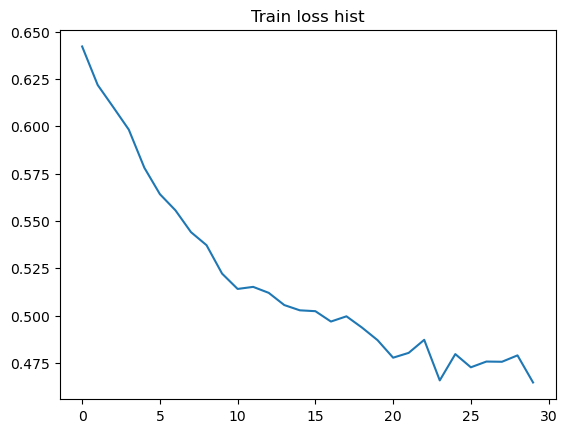

In [23]:
plt.plot(training_history['train_loss'], label='train loss')
plt.title('Train loss hist')
plt.show()

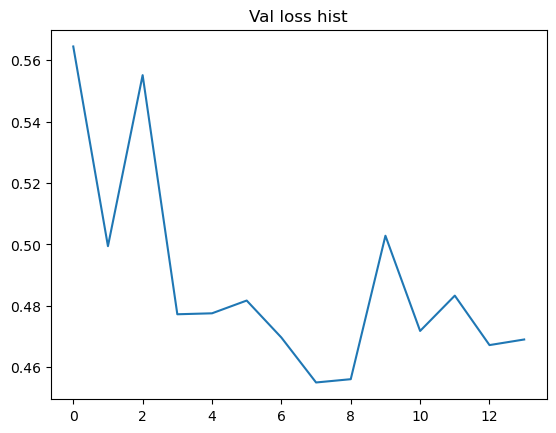

In [24]:
plt.plot(training_history['val_loss'])
plt.title('Val loss hist')
plt.show()

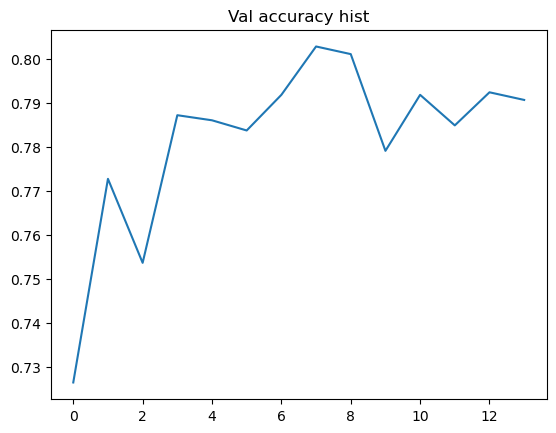

In [26]:
plt.plot(training_history['val_acc'])
plt.title('Val accuracy hist')
plt.show()